# Trying to do some translation

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from pathlib import Path
import torch
import re
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
BATCH_SIZE = 16

SHUFFEL_SIZE = 1024

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

learning_rate = 3e-5

In [3]:
print(device)

cuda:0


## Define Model

In [4]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

# model_size = "t5-small"
model_size = "t5-base"

tokenizer = T5Tokenizer.from_pretrained(model_size)
model = T5ForConditionalGeneration.from_pretrained(model_size).to(device)

task_specific_params = model.config.task_specific_params
if task_specific_params is not None:
    model.config.update(task_specific_params.get("translation_en_to_de", {}))
    

optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate, weight_decay=0.0001)

In [5]:
task_specific_params.get("translation_en_to_de", {}).get("max_length"), model.config.prefix

(300, 'translate English to German: ')

In [6]:
# model.config

## Define Pytorch Dataset

In [7]:
def read_files():
    de_path = "../../data/translate_en_de/train.de"
    en_path = "../../data/translate_en_de/train.en"
    
    de = [x.rstrip() for x in open(de_path).readlines()]
    en = [x.rstrip() for x in open(en_path).readlines()]
    
    assert len(de) == len(en)
    return en, de

In [8]:
en, de = read_files()

In [9]:
len_ds = len(en)

length_sent = np.zeros(len_ds)
for i, en_i in enumerate(en):
    length_sent[i] = len(en_i.split(" "))
np.mean(length_sent), np.median(length_sent)

(25.977565766507638, 23.0)

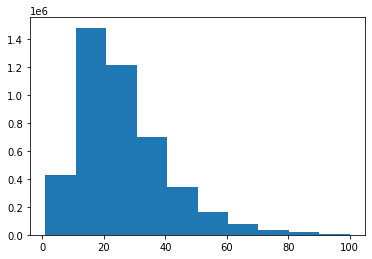

In [10]:
plt.hist(length_sent)
plt.show()

In [11]:
length_sent = 60

In [12]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, en, de):
        self.x = en
        self.y = de
        
    def __getitem__(self, index):
        x = tokenizer.encode_plus(model.config.prefix + self.transfrom(self.x[index]), max_length=length_sent, return_tensors="pt", pad_to_max_length=True)
        y = tokenizer.encode(self.transfrom(self.y[index]), max_length=length_sent, return_tensors="pt", pad_to_max_length=True)
        return x['input_ids'].view(-1), x['attention_mask'].view(-1), y.view(-1)
    
    @staticmethod
    def transfrom(x):
        x = x.lower()
        x = re.sub("'(.*)'", r"\1", x)
        return x
    
    def __len__(self):
        return len(self.x)

In [13]:
train_ds = MyDataset(en, de)

In [14]:
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE)

In [15]:
pad_token_id = tokenizer.pad_token_id
def step(inputs_ids, attention_mask, y):
    y_ids = y[:, :-1].contiguous()
    lm_labels = y[:, 1:].clone()
    lm_labels[y[:, 1:] == pad_token_id] = -100
    output = model(inputs_ids, attention_mask=attention_mask, decoder_input_ids=y_ids, lm_labels=lm_labels)
    return output[0] # loss

In [16]:
EPOCHS = 1
log_interval = 200
train_loss = []

for epoch in range(EPOCHS):
    model.train() 
    start_time = time.time()
    for i, (inputs_ids, attention_mask, y) in enumerate(train_loader):
        inputs_ids = inputs_ids.to(device)
        attention_mask = attention_mask.to(device)
        y = y.to(device)
        
        
        optimizer.zero_grad()
        loss = step(inputs_ids, attention_mask, y)
        train_loss.append(loss.item())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
            
        if (i + 1) % log_interval == 0:
            print(i, loss.item())

199 2.4130284786224365
399 2.134303569793701
599 1.4194481372833252
799 2.0240707397460938
999 2.4813971519470215
1199 1.4019087553024292
1399 2.1098015308380127
1599 3.531038999557495
1799 1.402091383934021
1999 1.651566743850708
2199 2.6524617671966553
2399 2.8673360347747803
2599 3.580836296081543
2799 2.480933904647827
2999 2.757979393005371
3199 1.365513801574707
3399 3.3866169452667236
3599 1.842129111289978
3799 3.3752963542938232
3999 1.3041448593139648
4199 1.7676128149032593
4399 1.0224708318710327
4599 2.3089587688446045
4799 1.7186954021453857
4999 1.8774501085281372
5199 3.19661545753479
5399 2.772386312484741
5599 1.6177871227264404
5799 1.7000313997268677
5999 1.8745511770248413
6199 1.6410698890686035
6399 3.2342870235443115
6599 1.0362801551818848
6799 1.3629732131958008
6999 1.1411058902740479
7199 1.7886000871658325
7399 2.627289056777954
7599 1.237229347229004
7799 1.610682487487793
7999 2.6627912521362305
8199 2.18442702293396
8399 1.4573791027069092
8599 2.1195652

KeyboardInterrupt: 

In [21]:
def read_files(name):
    article_path = "../data/%s/article" % name
    highlights_path = "../data/%s/highlights" % name
    
    articles = [x.rstrip() for x in open(article_path).readlines()]
    highlights = [x.rstrip() for x in open(highlights_path).readlines()]
    
    assert len(articles) == len(highlights)
    return articles, highlights

In [22]:
from segtok.segmenter import split_single

def split_in_sentences(text):
    return split_single(text)

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, articles):
        self.x = articles
        
    def __getitem__(self, index):
        sentences = split_in_sentences(self.x[index]) 
        ret_x = []
        for i, sent in enumerate(sentences): 
            if i == 0 and sent[:2] == "By":
                print(sent)
            else:
                x = tokenizer.encode_plus(model.config.prefix + self.transfrom(sent), max_length=100, return_tensors="pt", pad_to_max_length=True)
                ret_x.append((x['input_ids'].view(-1), x['attention_mask'].view(-1)))
        
        return ret_x
    
    @staticmethod
    def transfrom(x):
        x = x.lower()
        x = re.sub("'(.*)'", r"\1", x)
        return x
    
    def __len__(self):
        return len(self.x)

In [23]:
ds_name = "train"
articles, highlights = read_files(ds_name)

In [25]:
articles_ds = MyDataset(articles)
highlights_ds = MyDataset(highlights)

articles_loader = torch.utils.data.DataLoader(articles_ds, batch_size=1)
highlights_loader = torch.utils.data.DataLoader(highlights_ds, batch_size=1)

In [24]:
class FileWriter:
    def __init__(self, ds_name, name, path="../data/"):
        self.file = Path(path + ds_name + "/"+ name + "_german").open("w")
        
    def write_translated(self, list_str):    
        result = ""
        for item_str in list_str:
            result += item_str + " "
            
            
        self.file.write(result.replace("\n", " ") + "\n")
        self.file.flush()

In [26]:
def translate(loader, ds_name, name):
    file_writer = FileWriter(ds_name, name)
    for i, x_list in enumerate(loader):
        if i % 100 == 0:
            print(i)
        
        predictions = []
        for x, x_mask in x_list:
            x = x.to(device)
            x_mask = x_mask.to(device)
            translations = model.generate(input_ids=x, attention_mask=x_mask)
            pred = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in translations]
            predictions.append(pred[0])  
        file_writer.write_translated(predictions)
          
translate(articles_loader, "train", "articles")

By . Associated Press . PUBLISHED: . 14:11 EST, 25 October 2013 . | . UPDATED: . 15:36 EST, 25 October 2013 . The bishop of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A virus in late September and early October.
0


KeyboardInterrupt: 